# Localizing Multiple Cells Using LodeSTAR

This notebook provides you with a complete code example that trains a convolutional neural network to detect cells using a single crop of a cell and, then, it evaluates the performance of the trained network on all the images available in the sequence.

## Using the Cell Tracking Challenge Dataset

You’ll use a dataset from the Cell Tracking Challenge, which includes a series of videos of proliferating mouse hematopoietic stem cells. Even though
you don’t need ground truth positions to train the neural network, you can use the annotations provided for the challenge to evaluate the detection performance of your trained network.

Download the BF-C2DL-HSC dataset of the Cell Tracking Challenge ...

In [1]:
import os
from torchvision.datasets.utils import download_url, _extract_zip

dataset_path = os.path.join(".", "cell_detection_dataset")
if not os.path.exists(dataset_path):
    url = ("http://data.celltrackingchallenge.net/training-datasets/"
           "BF-C2DL-HSC.zip")
    download_url(url, ".")
    _extract_zip("BF-C2DL-HSC.zip", dataset_path, None)
    os.remove("BF-C2DL-HSC.zip")

dir = os.path.join(dataset_path, "BF-C2DL-HSC")

... create the pipeline to load the images and the relative ground truth cell positions ...

In [2]:
import glob
import deeptrack as dt
from skimage.measure import regionprops

sources = dt.sources.Source(
    image_path=sorted(glob.glob(os.path.join(dir, "02", "*.tif"))),
    label_path=sorted(glob.glob(os.path.join(dir, "02_GT", "TRA", "*.tif"))),
)

image_pip = dt.LoadImage(sources.image_path)[300:850, :300] / 256
props_pip = dt.LoadImage(sources.label_path)[300:850, :300] >> regionprops

pip = image_pip & props_pip

... and plot some images with the cell ground truth positions.

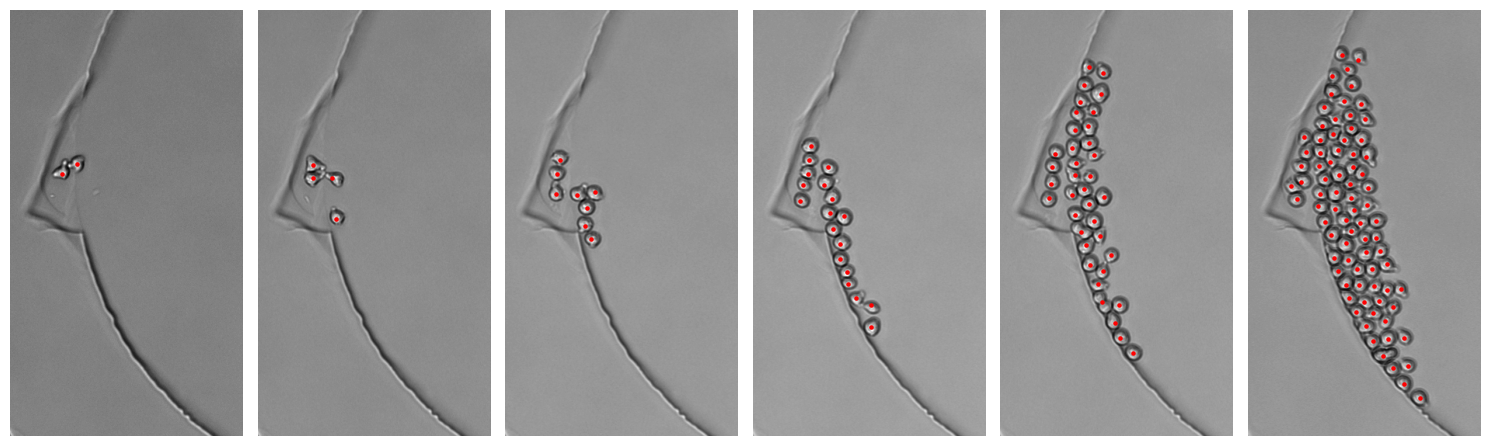

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))

for plt_index, data_index in enumerate([0, 300, 600, 900, 1200, 1500]):
    image, *props = pip(sources[data_index])
    
    plt.subplot(1, 6, plt_index + 1)
    plt.imshow(image, cmap="gray")
    for prop in props:
        plt.scatter(prop.centroid[1], prop.centroid[0], s=5, color="red")
    plt.axis("off")

plt.tight_layout()
plt.show()

## Preparing the Training Crop

Prepare the training crop ...

In [5]:
crop_frame_index, crop_size = 282, 50
crop_x0, crop_y0 = 295 - crop_size // 2, 115 - crop_size // 2

image, *props = pip(sources[crop_frame_index])
crop = image[crop_x0:crop_x0 + crop_size, crop_y0:crop_y0 + crop_size]

... and plot it.

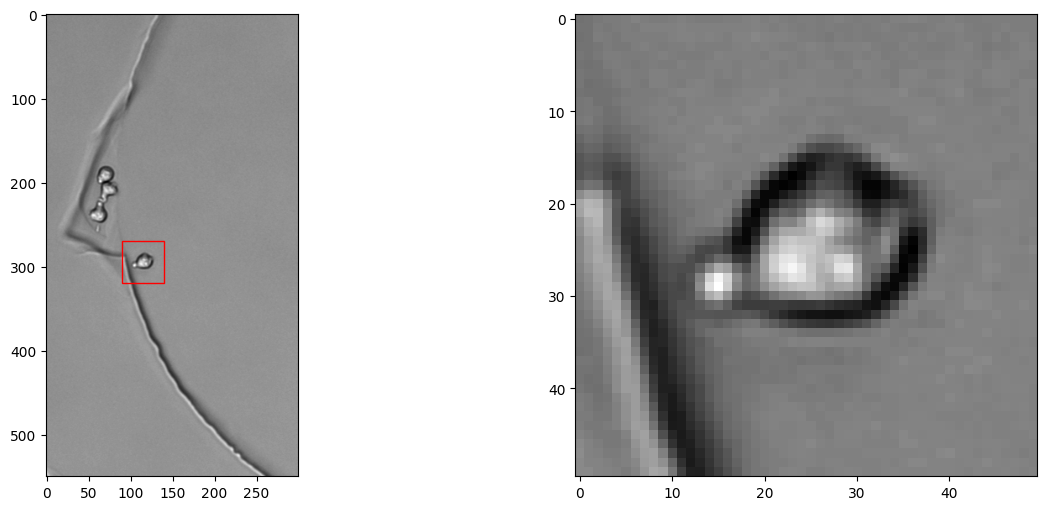

In [6]:
import matplotlib.patches as patches

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap="gray")
plt.gca().add_patch(patches.Rectangle((crop_y0, crop_x0), crop_size, crop_size,
    linewidth=1, edgecolor="r", facecolor="none"))

plt.subplot(1, 2, 2)
plt.imshow(crop, cmap="gray")

plt.show()

## Creating the Training Pipeline and Data Loader

Create the training pipeline ...

In [7]:
import numpy as np
import torch

train_pip = (dt.Value(crop) >> dt.Multiply(lambda: np.random.uniform(0.9, 1.1))
             >> dt.Add(lambda: np.random.uniform(-0.1, 0.1))
             >> dt.MoveAxis(-1, 0) >> dt.pytorch.ToTensor(dtype=torch.float32))

... and the dataset and data loader.

In [8]:
import deeplay as dl 

train_dataset = dt.pytorch.Dataset(train_pip, length=400, replace=False)
dataloader = dl.DataLoader(train_dataset, batch_size=8, shuffle=True)

## Training the Neural Network

Define and train the LodeSTAR neural network ...

In [9]:
lodestar = dl.LodeSTAR(n_transforms=4, optimizer=dl.Adam(lr=1e-4)).build()
trainer = dl.Trainer(max_epochs=200)
trainer.fit(lodestar, dataloader)

/Users/giovannivolpe/Documents/GitHub/deeplay/py_env_dlcc/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/Users/giovannivolpe/Documents/GitHub/deeplay/py_env_dlcc/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/Users/giovannivolpe/Documents/GitHub/deeplay/py_env_dlcc/lib/python3.12/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:454: A layer with UninitializedParameter was found. Thus, 

┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name          ┃ Type                       ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model         │ ConvolutionalNeuralNetwork │  251 K │
│ 1 │ between_loss  │ L1Loss                     │      0 │
│ 2 │ within_loss   │ L1Loss                     │      0 │
│ 3 │ train_metrics │ MetricCollection           │      0 │
│ 4 │ val_metrics   │ MetricCollection           │      0 │
│ 5 │ test_metrics  │ MetricCollection           │      0 │
│ 6 │ optimizer     │ Adam                       │      0 │
└───┴───────────────┴────────────────────────────┴────────┘

Trainable params: 251 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 251 K                                                                                                
Total estimated model params size (MB): 1

Output()

/Users/giovannivolpe/Documents/GitHub/deeplay/py_env_dlcc/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


... and plot its predictions.

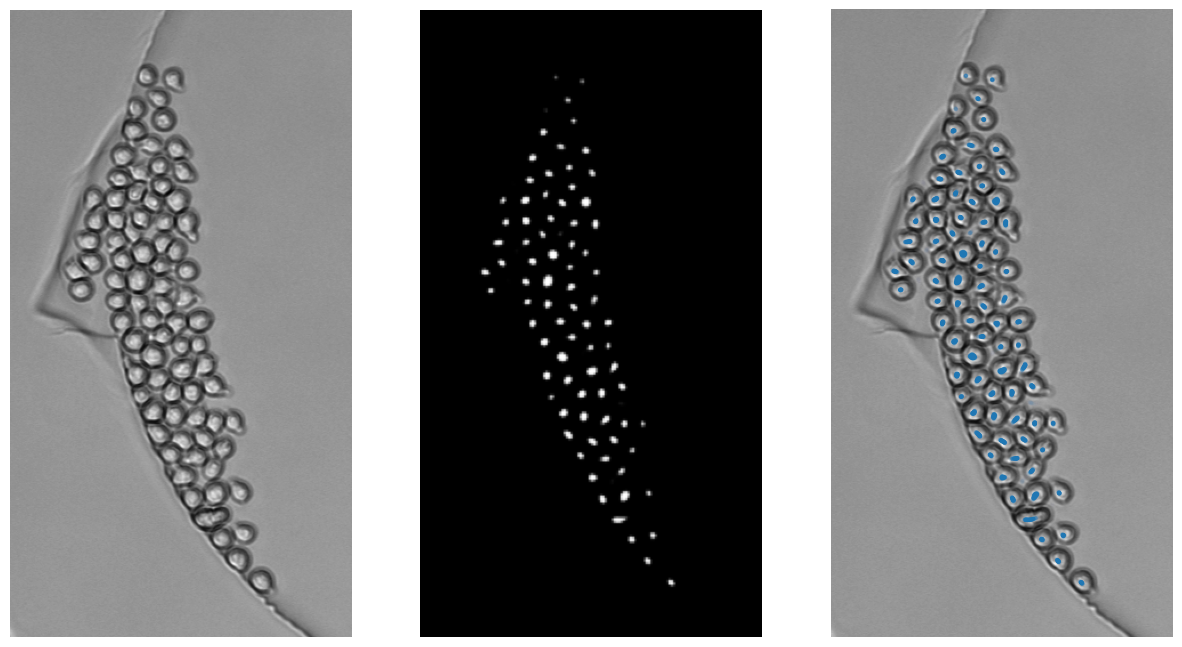

In [10]:
image_index = 1500
image, *props = pip(sources[image_index])
torch_image = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0).float()
prediction = lodestar(torch_image)[0].detach().numpy()
x, y, rho = prediction[0], prediction[1], prediction[-1]

plt.figure(figsize=(15, 10))

plt.subplot(1, 3, 1)
plt.imshow(image, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(rho, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(image, cmap="gray")
plt.scatter(y.flatten(), x.flatten(), alpha=rho.flatten() / rho.max(), s=5)
plt.axis("off"); plt.xlim(0, 299); plt.ylim(0, 549); plt.gca().invert_yaxis()

plt.show()

## Evaluating the Performance of the Trained Network

Fix the parameters to determine the positions of the cells in the images ...

In [11]:
alpha = 0.2
beta = 1 - alpha
cutoff = 0.2
mode = "constant"

... determine and plot the positions of the cells in the images ...

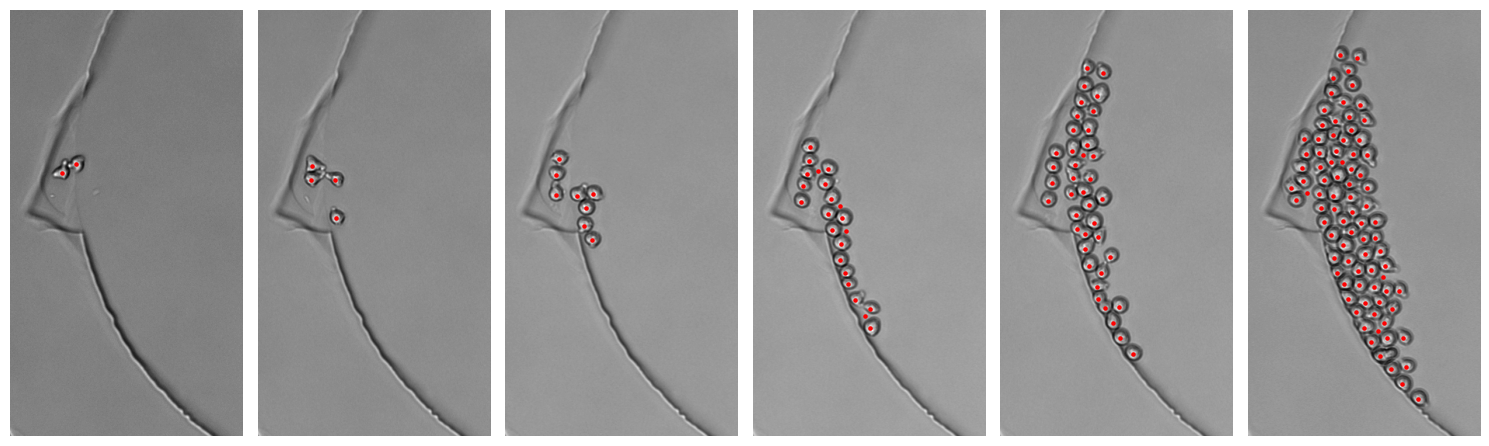

In [12]:
plt.figure(figsize=(15, 10))

for plot_idx, frame_idx in enumerate([0, 300, 600, 900, 1200, 1500]):
    image, *props = pip(sources[frame_idx])
    torch_image = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0).float()
    detections = lodestar.detect(torch_image, alpha=alpha, beta=beta, 
                                 mode="constant", cutoff=cutoff)[0]

    plt.subplot(1, 6, plot_idx + 1)
    plt.imshow(image, cmap="gray")
    plt.scatter(detections[:, 1], detections[:, 0], s=5, color="red")
    plt.axis("off")
plt.tight_layout()
plt.show()

... and calculate the F1-score to quantify the neural network performance.

In [13]:
import scipy, tqdm

distance_th = 10

TP, FP, FN = 0, 0, 0
for source in tqdm.tqdm(sources[::10]):
    image, *props = pip(source)
    torch_image = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0).float()
    detections = lodestar.detect(torch_image, alpha=alpha, beta=beta,
                              mode="constant", cutoff=cutoff)[0]
    centroids = np.array([prop.centroid[:2] for prop in props])

    distance_matrix = scipy.spatial.distance_matrix(detections, centroids)
    row_idx, col_idx = scipy.optimize.linear_sum_assignment(distance_matrix)

    filtered_row_ind = row_idx[distance_matrix[row_idx, col_idx] < distance_th]
    filtered_col_ind = col_idx[distance_matrix[row_idx, col_idx] < distance_th]

    TP += len(filtered_row_ind)
    FP += len(detections) - len(filtered_row_ind)
    FN += len(centroids) - len(filtered_col_ind)

F1 = 2 * TP / (2 * TP + FP + FN)

print(f"TP: {TP} FP: {FP} FN: {FN} F1: {F1}")

100%|██████████| 177/177 [00:21<00:00,  8.40it/s]

TP: 6393 FP: 517 FN: 43 F1: 0.9580398621309756
